In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trees-dataset/full_numpy_bitmap_tree.npy


In [2]:
import numpy as np
import os

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop
 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
input_images = "/kaggle/input/trees-dataset/full_numpy_bitmap_tree.npy"

In [5]:
data = np.load(input_images)

In [6]:
data.shape

(144721, 784)

In [7]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        13,  72,  70,   1,   0,  17,  32,  11,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  46, 220, 255, 255, 215, 230, 255, 255, 255, 244, 196,  55,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  59, 244, 223,  69,  90, 183, 152, 109,  90, 11

In [8]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) 
img_w,img_h = data.shape[1:3]
data.shape

(144721, 28, 28, 1)

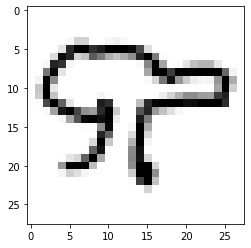

In [9]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

In [10]:
def discriminator_builder(depth=64,p=0.4):

    inputs = Input((img_w,img_h,1))
    
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    output = Dense(1, activation='sigmoid')(conv4)

    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [11]:
discriminator = discriminator_builder()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)        

In [12]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), 
                      metrics=['accuracy'])

In [13]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    
    inputs = Input((z_dim,))
    
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
  
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [14]:
generator = generator_builder()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544     
_________________________________________________________________
activation (Activation)      (None, 3136)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)       

In [15]:
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])
    model.summary()
    return model

In [16]:
adversarial_model = adversarial_builder()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 28, 28, 1)         396961    
_________________________________________________________________
functional_1 (Functional)    (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


In [17]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [18]:
def train(epochs=1000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%100 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

0
Epoch #100
99: [D loss: 0.477261, acc: 0.933041]  [A loss: 2.622191, acc: 0.531723]


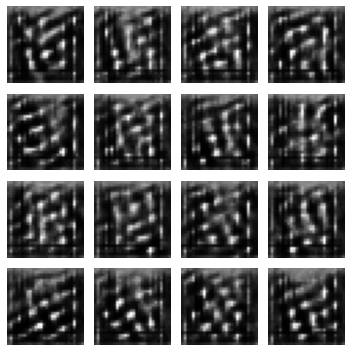

100
Epoch #200
199: [D loss: 0.457332, acc: 0.879338]  [A loss: 2.246099, acc: 0.282192]


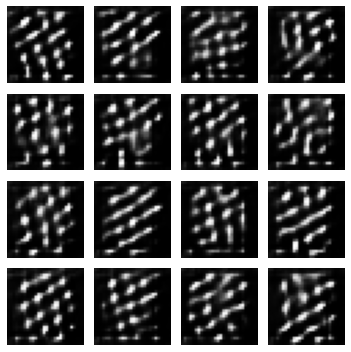

200
Epoch #300
299: [D loss: 0.493237, acc: 0.836983]  [A loss: 2.128603, acc: 0.202158]


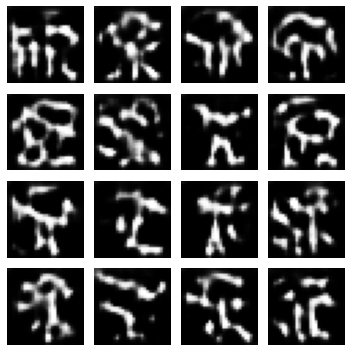

300
Epoch #400
399: [D loss: 0.529924, acc: 0.796611]  [A loss: 1.971393, acc: 0.176750]


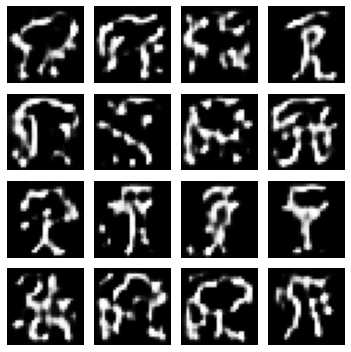

400
Epoch #500
499: [D loss: 0.554591, acc: 0.762760]  [A loss: 1.809938, acc: 0.163154]


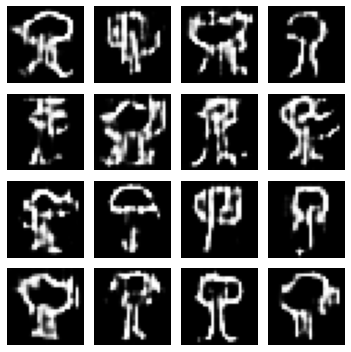

500
Epoch #600
599: [D loss: 0.572380, acc: 0.737238]  [A loss: 1.676529, acc: 0.154594]


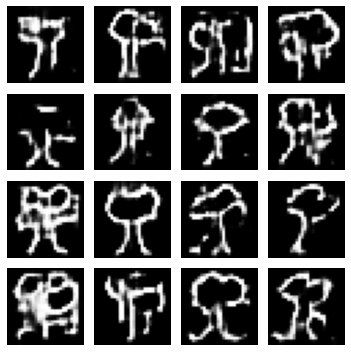

600
Epoch #700
699: [D loss: 0.584686, acc: 0.720119]  [A loss: 1.570481, acc: 0.151075]


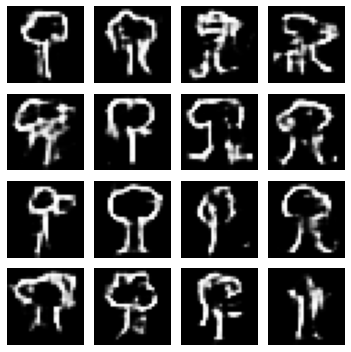

700
Epoch #800
799: [D loss: 0.590983, acc: 0.710742]  [A loss: 1.500042, acc: 0.146814]


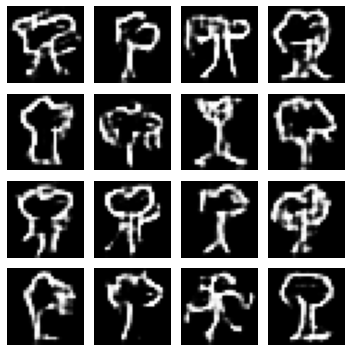

800
Epoch #900
899: [D loss: 0.593739, acc: 0.705689]  [A loss: 1.455618, acc: 0.143302]


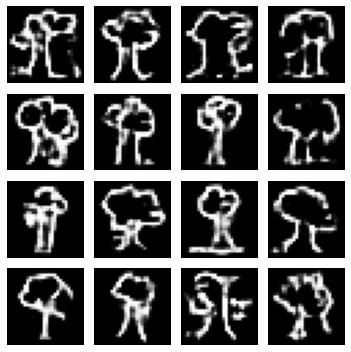

900
Epoch #1000
999: [D loss: 0.594446, acc: 0.703231]  [A loss: 1.428361, acc: 0.140383]


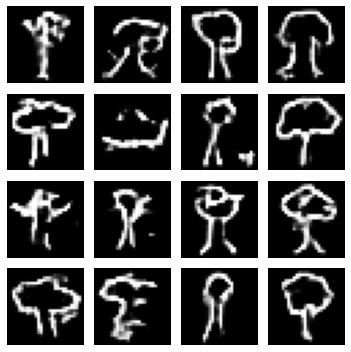

1000
Epoch #1100
1099: [D loss: 0.595958, acc: 0.701092]  [A loss: 1.410194, acc: 0.138521]


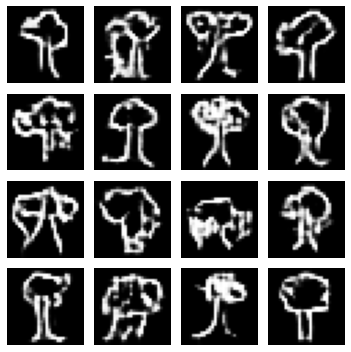

1100
Epoch #1200
1199: [D loss: 0.597391, acc: 0.698857]  [A loss: 1.394857, acc: 0.137139]


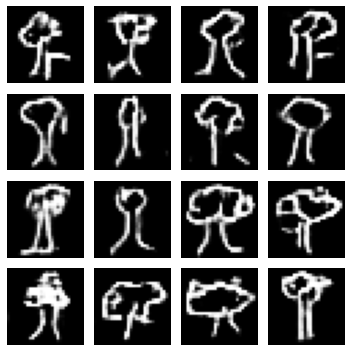

1200
Epoch #1300
1299: [D loss: 0.598869, acc: 0.696735]  [A loss: 1.383424, acc: 0.136433]


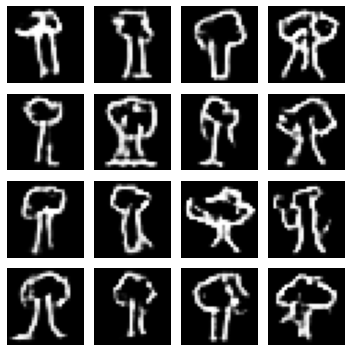

1300
Epoch #1400
1399: [D loss: 0.600178, acc: 0.695455]  [A loss: 1.373859, acc: 0.136509]


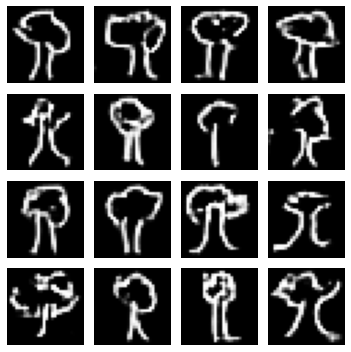

1400
Epoch #1500
1499: [D loss: 0.600691, acc: 0.694742]  [A loss: 1.366448, acc: 0.136231]


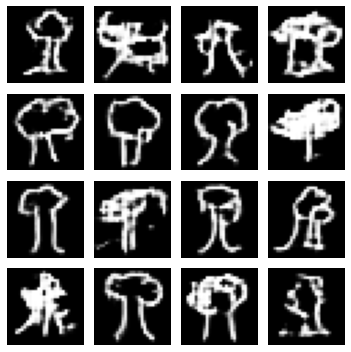

1500
Epoch #1600
1599: [D loss: 0.600819, acc: 0.694484]  [A loss: 1.362474, acc: 0.135803]


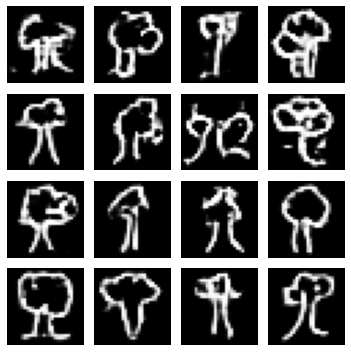

1600
Epoch #1700
1699: [D loss: 0.599761, acc: 0.694958]  [A loss: 1.361733, acc: 0.135558]


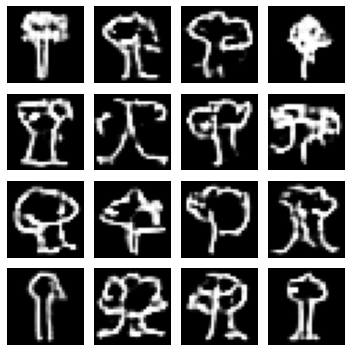

1700
Epoch #1800
1799: [D loss: 0.598842, acc: 0.695386]  [A loss: 1.360826, acc: 0.135010]


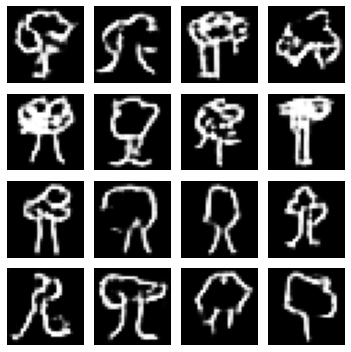

1800
Epoch #1900
1899: [D loss: 0.596855, acc: 0.696845]  [A loss: 1.363707, acc: 0.134228]


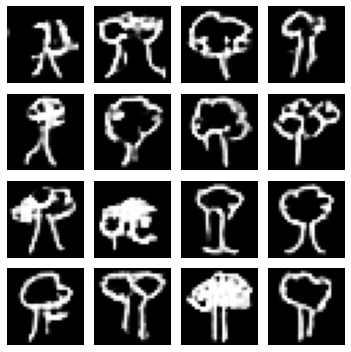

1900
Epoch #2000
1999: [D loss: 0.595301, acc: 0.698281]  [A loss: 1.371161, acc: 0.133242]


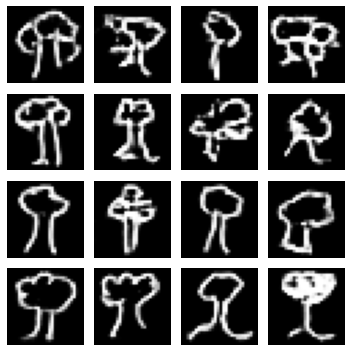

2000
Epoch #2100
2099: [D loss: 0.593754, acc: 0.699494]  [A loss: 1.378348, acc: 0.131897]


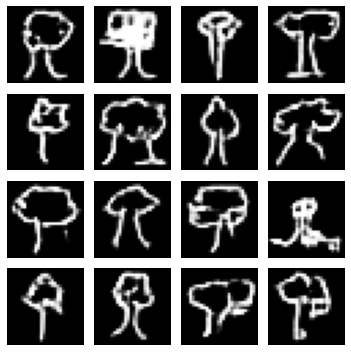

2100
Epoch #2200
2199: [D loss: 0.593065, acc: 0.700704]  [A loss: 1.387534, acc: 0.130816]


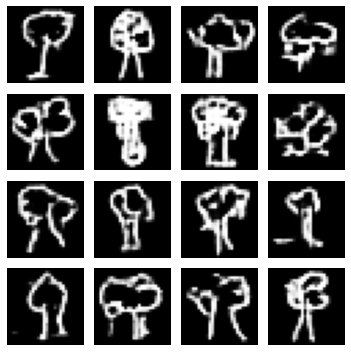

2200
Epoch #2300
2299: [D loss: 0.592337, acc: 0.701421]  [A loss: 1.396822, acc: 0.130189]


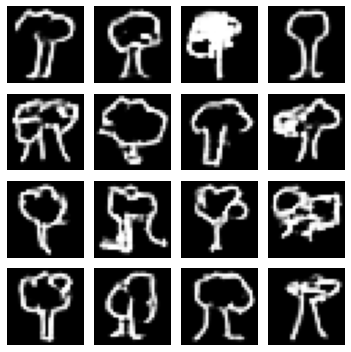

2300
Epoch #2400
2399: [D loss: 0.590697, acc: 0.702651]  [A loss: 1.406489, acc: 0.129279]


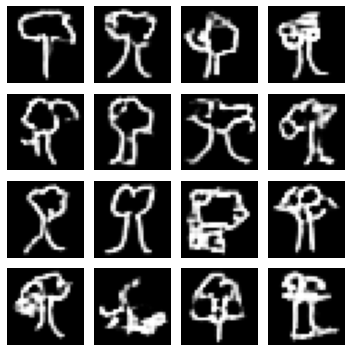

2400
Epoch #2500
2499: [D loss: 0.588418, acc: 0.704358]  [A loss: 1.420245, acc: 0.128026]


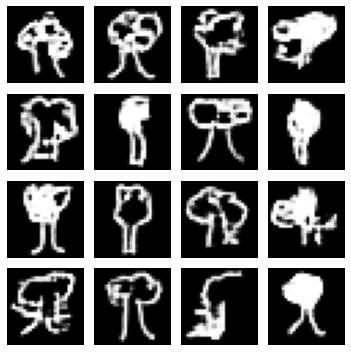

2500
Epoch #2600
2599: [D loss: 0.586260, acc: 0.705939]  [A loss: 1.433216, acc: 0.126975]


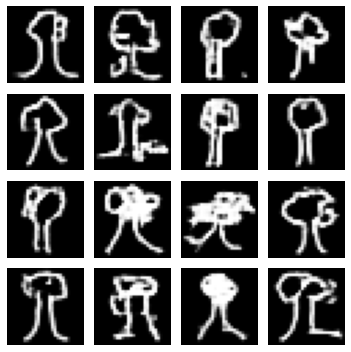

2600
Epoch #2700
2699: [D loss: 0.583978, acc: 0.707753]  [A loss: 1.447785, acc: 0.126010]


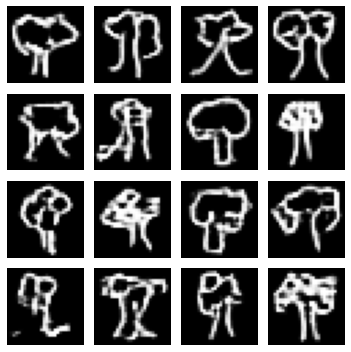

2700
Epoch #2800
2799: [D loss: 0.581581, acc: 0.709577]  [A loss: 1.463247, acc: 0.124763]


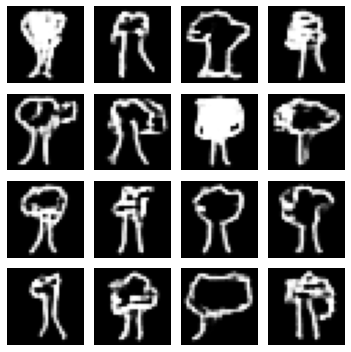

2800
Epoch #2900
2899: [D loss: 0.579142, acc: 0.711412]  [A loss: 1.480180, acc: 0.123787]


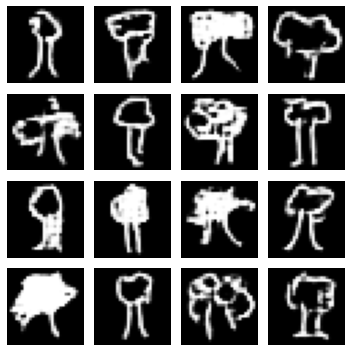

2900
Epoch #3000
2999: [D loss: 0.576621, acc: 0.713393]  [A loss: 1.498602, acc: 0.122622]


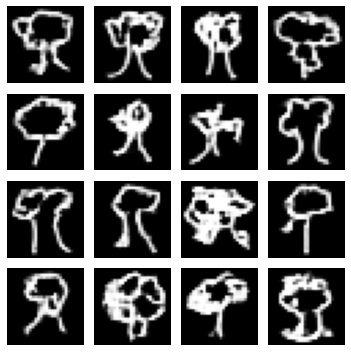

3000
Epoch #3100
3099: [D loss: 0.574494, acc: 0.715039]  [A loss: 1.517701, acc: 0.121720]


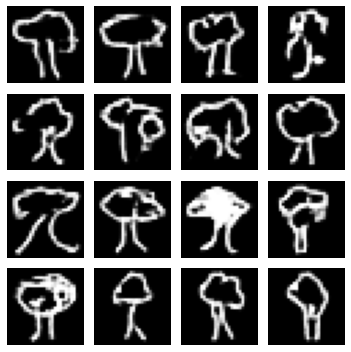

3100
Epoch #3200
3199: [D loss: 0.572153, acc: 0.716832]  [A loss: 1.537225, acc: 0.120692]


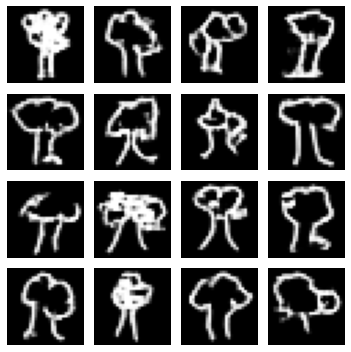

3200
Epoch #3300
3299: [D loss: 0.570306, acc: 0.718243]  [A loss: 1.555905, acc: 0.119788]


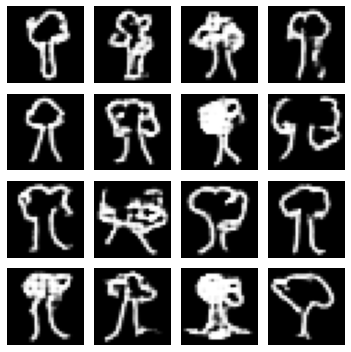

3300
Epoch #3400
3399: [D loss: 0.568209, acc: 0.719880]  [A loss: 1.575672, acc: 0.118824]


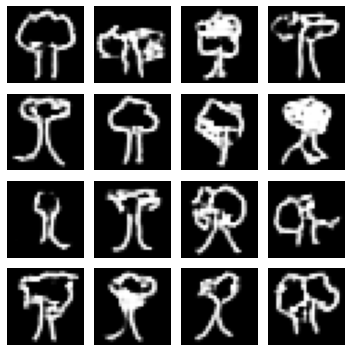

3400
Epoch #3500
3499: [D loss: 0.566504, acc: 0.721263]  [A loss: 1.596121, acc: 0.117900]


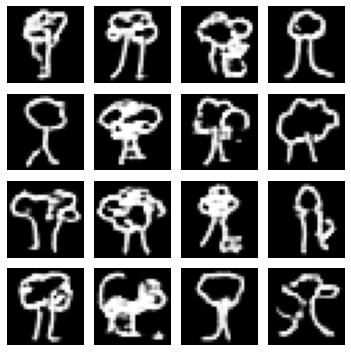

3500
Epoch #3600
3599: [D loss: 0.564537, acc: 0.722789]  [A loss: 1.616516, acc: 0.117168]


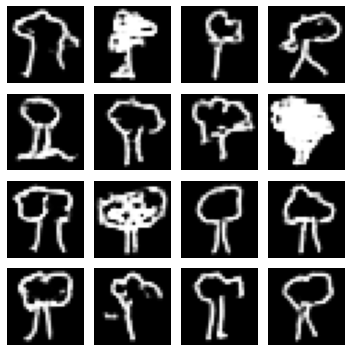

3600
Epoch #3700
3699: [D loss: 0.562795, acc: 0.724062]  [A loss: 1.636169, acc: 0.116438]


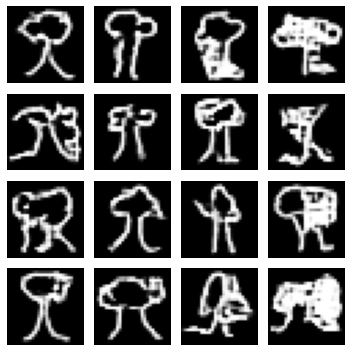

3700
Epoch #3800
3799: [D loss: 0.561039, acc: 0.725342]  [A loss: 1.656122, acc: 0.115746]


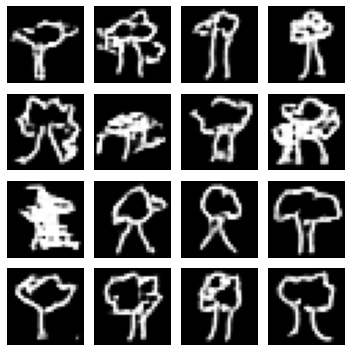

3800
Epoch #3900
3899: [D loss: 0.559419, acc: 0.726663]  [A loss: 1.677490, acc: 0.114969]


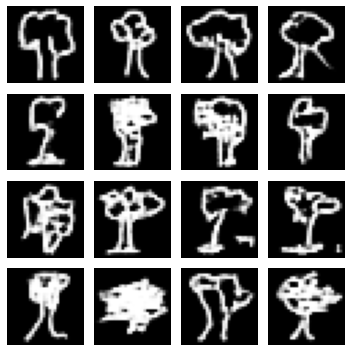

3900
Epoch #4000
3999: [D loss: 0.558859, acc: 0.727395]  [A loss: 1.694512, acc: 0.114409]


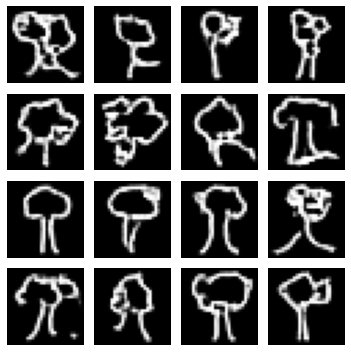

4000
Epoch #4100
4099: [D loss: 0.558055, acc: 0.728222]  [A loss: 1.712994, acc: 0.113742]


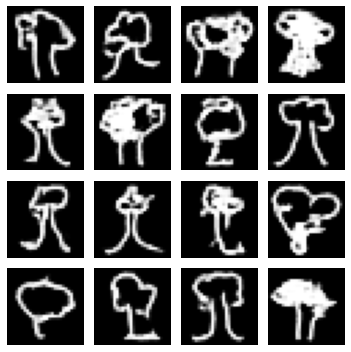

4100
Epoch #4200
4199: [D loss: 0.556943, acc: 0.729055]  [A loss: 1.730018, acc: 0.113288]


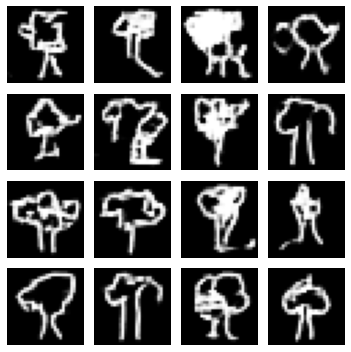

4200
Epoch #4300
4299: [D loss: 0.556115, acc: 0.729843]  [A loss: 1.747274, acc: 0.112868]


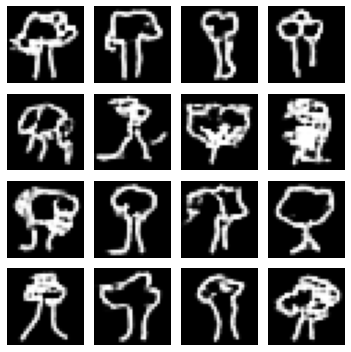

4300
Epoch #4400
4399: [D loss: 0.554972, acc: 0.730756]  [A loss: 1.766538, acc: 0.112284]


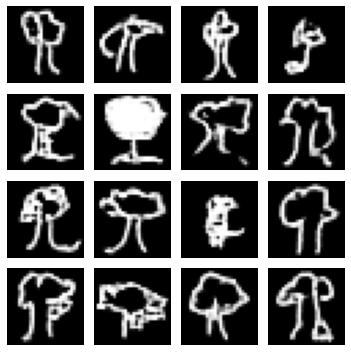

4400
Epoch #4500
4499: [D loss: 0.553908, acc: 0.731638]  [A loss: 1.783193, acc: 0.111872]


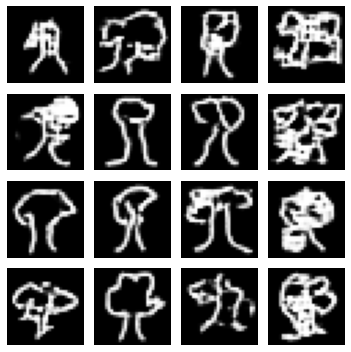

4500
Epoch #4600
4599: [D loss: 0.552979, acc: 0.732530]  [A loss: 1.801660, acc: 0.111498]


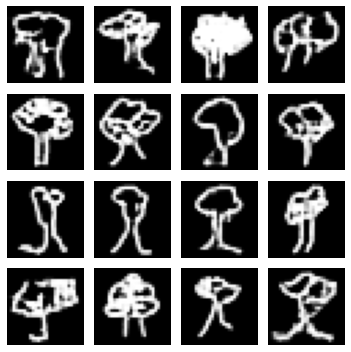

4600
Epoch #4700
4699: [D loss: 0.552275, acc: 0.733280]  [A loss: 1.821012, acc: 0.111054]


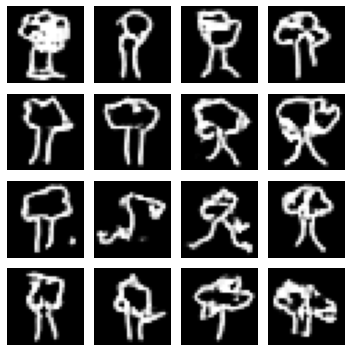

4700
Epoch #4800
4799: [D loss: 0.551194, acc: 0.734141]  [A loss: 1.837873, acc: 0.110697]


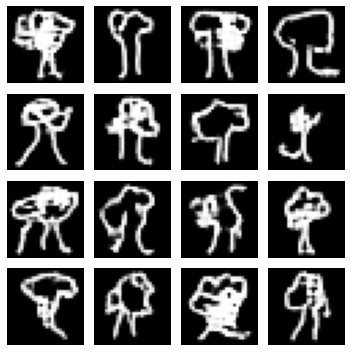

4800
Epoch #4900
4899: [D loss: 0.550244, acc: 0.735062]  [A loss: 1.856286, acc: 0.110217]


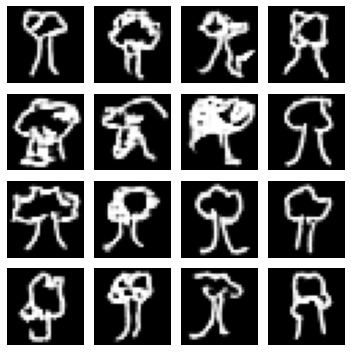

4900
Epoch #5000
4999: [D loss: 0.549295, acc: 0.735774]  [A loss: 1.873323, acc: 0.109838]


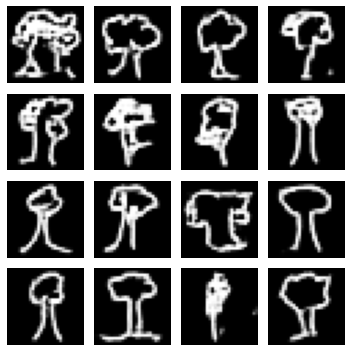

5000
Epoch #5100
5099: [D loss: 0.548391, acc: 0.736510]  [A loss: 1.889939, acc: 0.109464]


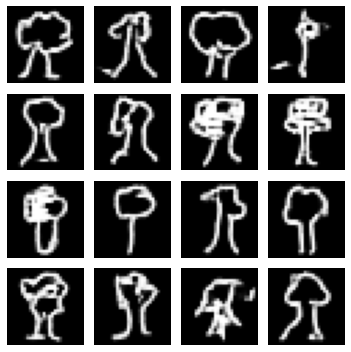

5100
Epoch #5200
5199: [D loss: 0.547527, acc: 0.737252]  [A loss: 1.905886, acc: 0.109226]


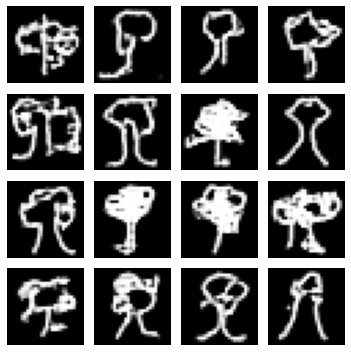

5200
Epoch #5300
5299: [D loss: 0.546648, acc: 0.737851]  [A loss: 1.919846, acc: 0.108936]


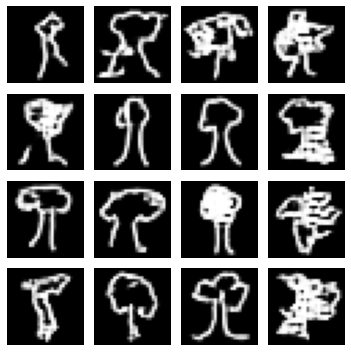

5300
Epoch #5400
5399: [D loss: 0.545856, acc: 0.738511]  [A loss: 1.935993, acc: 0.108683]


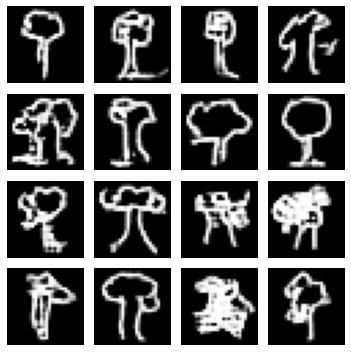

5400
Epoch #5500
5499: [D loss: 0.545134, acc: 0.739094]  [A loss: 1.948960, acc: 0.108312]


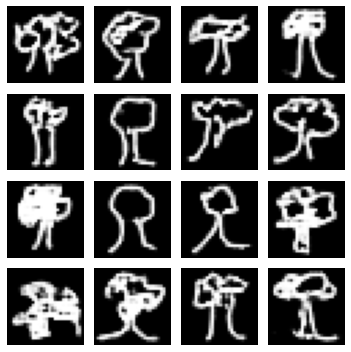

5500
Epoch #5600
5599: [D loss: 0.544514, acc: 0.739622]  [A loss: 1.960399, acc: 0.108109]


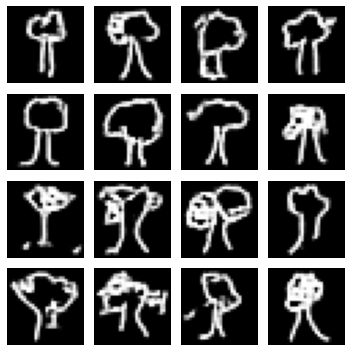

5600
Epoch #5700
5699: [D loss: 0.543824, acc: 0.740227]  [A loss: 1.970800, acc: 0.107863]


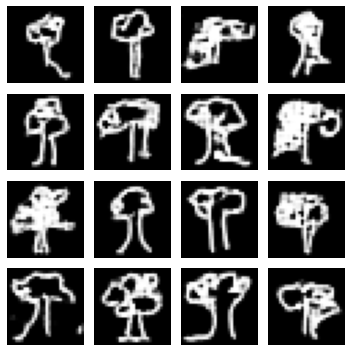

5700
Epoch #5800
5799: [D loss: 0.543108, acc: 0.740855]  [A loss: 1.979936, acc: 0.107536]


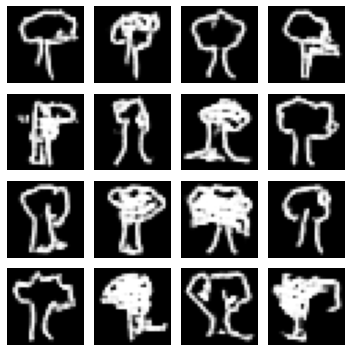

5800
Epoch #5900
5899: [D loss: 0.542455, acc: 0.741408]  [A loss: 1.989705, acc: 0.107296]


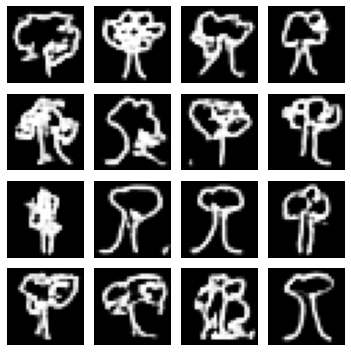

5900
Epoch #6000
5999: [D loss: 0.541989, acc: 0.741966]  [A loss: 2.000762, acc: 0.107119]


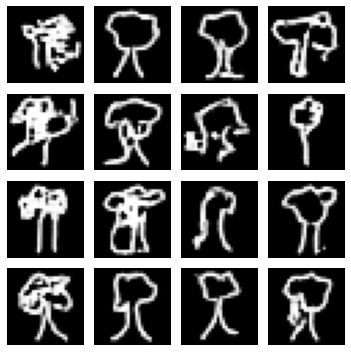

6000
Epoch #6100
6099: [D loss: 0.541503, acc: 0.742445]  [A loss: 2.007433, acc: 0.106928]


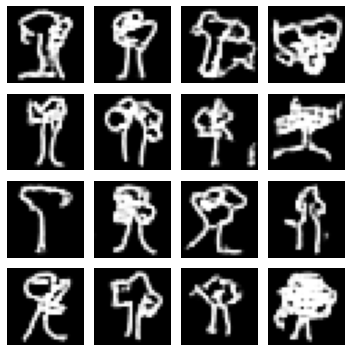

6100
Epoch #6200
6199: [D loss: 0.540958, acc: 0.742987]  [A loss: 2.017204, acc: 0.106664]


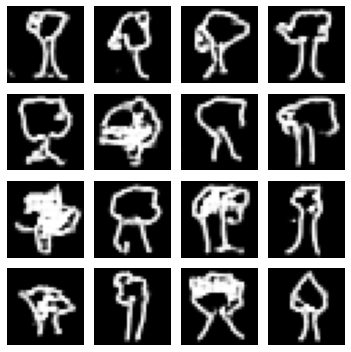

6200
Epoch #6300
6299: [D loss: 0.540317, acc: 0.743474]  [A loss: 2.027248, acc: 0.106424]


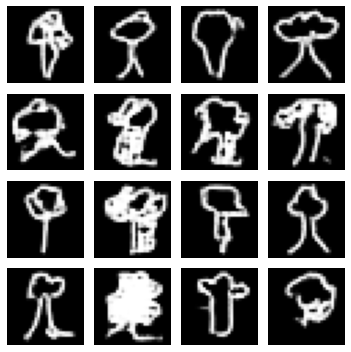

6300
Epoch #6400
6399: [D loss: 0.539702, acc: 0.743954]  [A loss: 2.036215, acc: 0.106169]


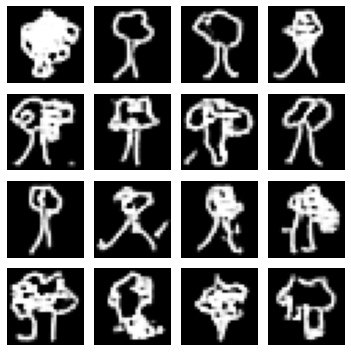

6400
Epoch #6500
6499: [D loss: 0.539328, acc: 0.744357]  [A loss: 2.045232, acc: 0.105924]


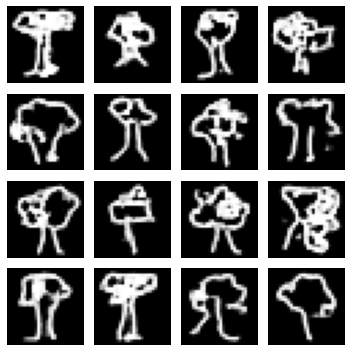

6500
Epoch #6600
6599: [D loss: 0.538648, acc: 0.744926]  [A loss: 2.055364, acc: 0.105653]


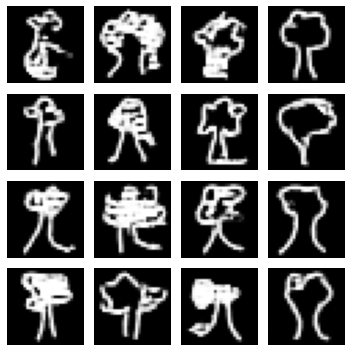

6600
Epoch #6700
6699: [D loss: 0.538565, acc: 0.745303]  [A loss: 2.065636, acc: 0.105560]


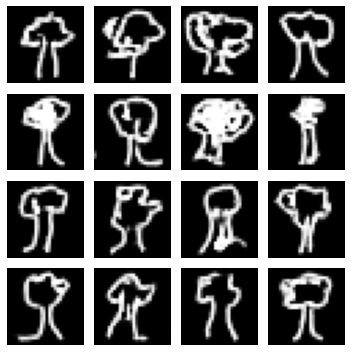

6700
Epoch #6800
6799: [D loss: 0.538157, acc: 0.745648]  [A loss: 2.073361, acc: 0.105391]


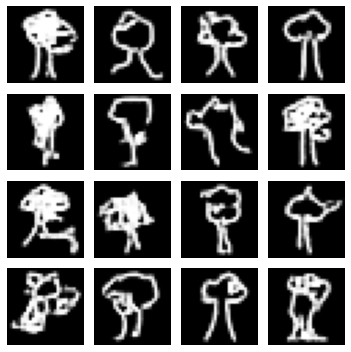

6800
Epoch #6900
6899: [D loss: 0.537668, acc: 0.746048]  [A loss: 2.081809, acc: 0.105232]


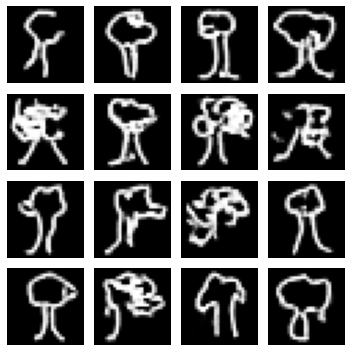

6900
Epoch #7000
6999: [D loss: 0.537446, acc: 0.746273]  [A loss: 2.087837, acc: 0.105166]


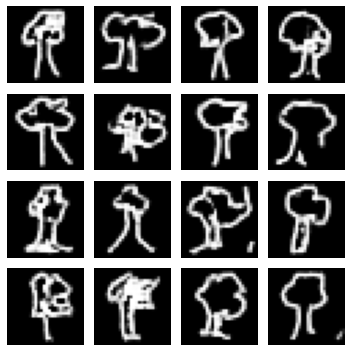

7000
Epoch #7100
7099: [D loss: 0.537144, acc: 0.746535]  [A loss: 2.094278, acc: 0.104998]


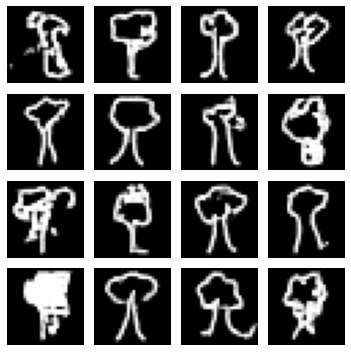

7100
Epoch #7200
7199: [D loss: 0.537021, acc: 0.746699]  [A loss: 2.100773, acc: 0.104960]


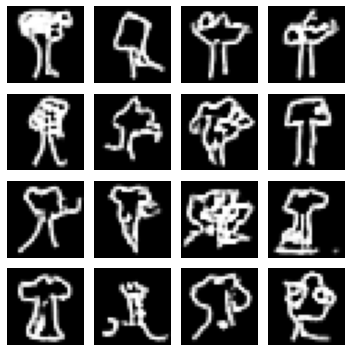

7200
Epoch #7300
7299: [D loss: 0.536912, acc: 0.746812]  [A loss: 2.106130, acc: 0.104939]


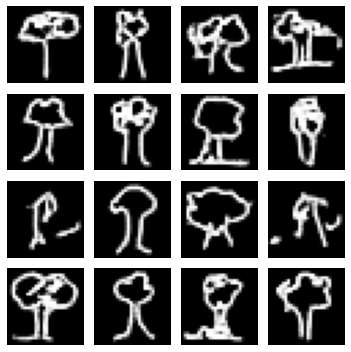

7300
Epoch #7400
7399: [D loss: 0.536819, acc: 0.746921]  [A loss: 2.109502, acc: 0.105014]


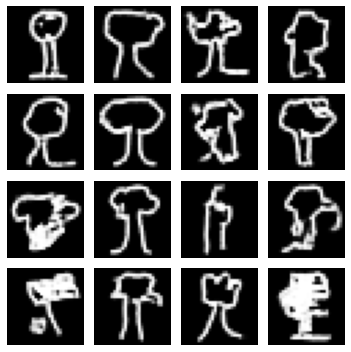

7400
Epoch #7500
7499: [D loss: 0.536774, acc: 0.747035]  [A loss: 2.114025, acc: 0.105017]


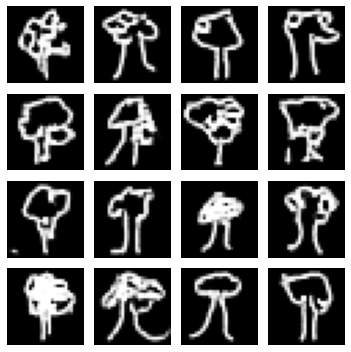

7500
Epoch #7600
7599: [D loss: 0.536718, acc: 0.747096]  [A loss: 2.117811, acc: 0.104993]


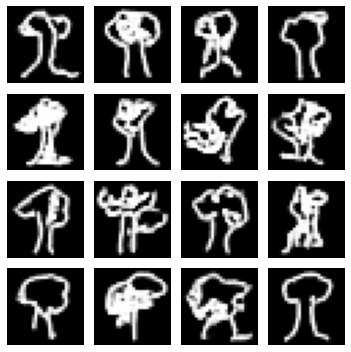

7600
Epoch #7700
7699: [D loss: 0.536756, acc: 0.747146]  [A loss: 2.121640, acc: 0.104987]


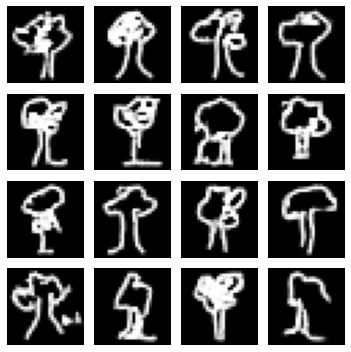

7700
Epoch #7800
7799: [D loss: 0.536799, acc: 0.747224]  [A loss: 2.123528, acc: 0.105053]


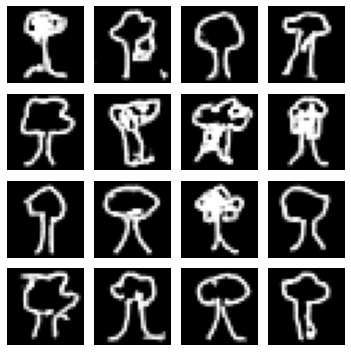

7800
Epoch #7900
7899: [D loss: 0.536851, acc: 0.747240]  [A loss: 2.123743, acc: 0.105139]


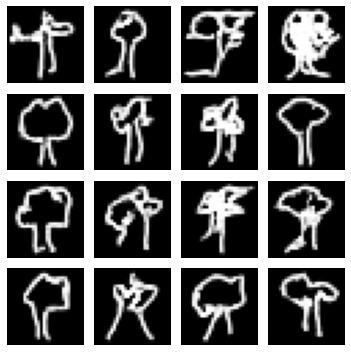

7900
Epoch #8000
7999: [D loss: 0.536903, acc: 0.747239]  [A loss: 2.124084, acc: 0.105132]


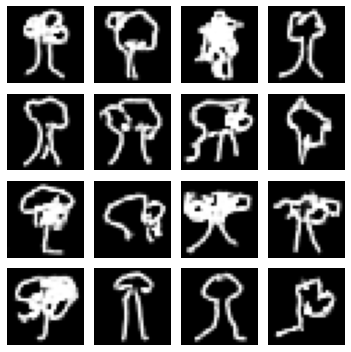

8000
Epoch #8100
8099: [D loss: 0.536949, acc: 0.747209]  [A loss: 2.123457, acc: 0.105252]


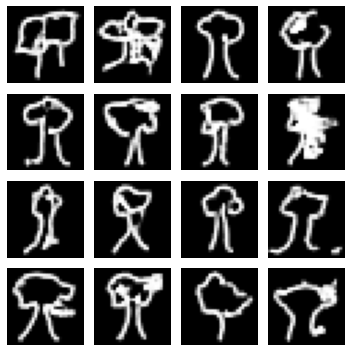

8100
Epoch #8200
8199: [D loss: 0.537287, acc: 0.747107]  [A loss: 2.124405, acc: 0.105367]


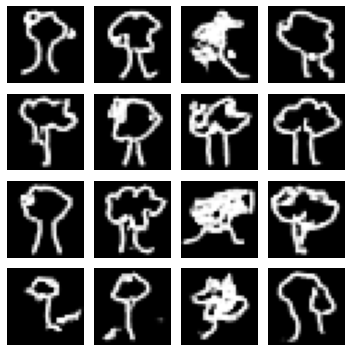

8200
Epoch #8300
8299: [D loss: 0.537436, acc: 0.746934]  [A loss: 2.122352, acc: 0.105377]


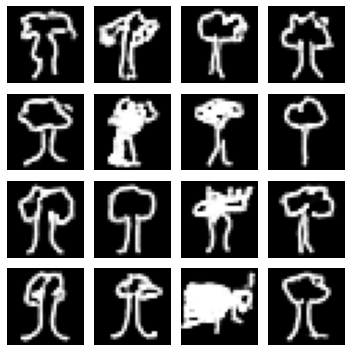

8300
Epoch #8400
8399: [D loss: 0.537596, acc: 0.746844]  [A loss: 2.119943, acc: 0.105473]


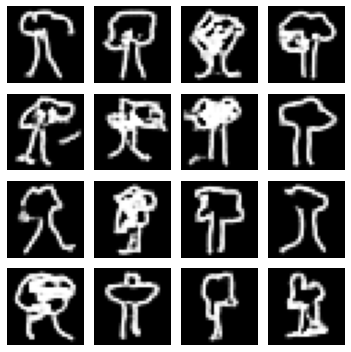

8400
Epoch #8500
8499: [D loss: 0.537903, acc: 0.746670]  [A loss: 2.117451, acc: 0.105543]


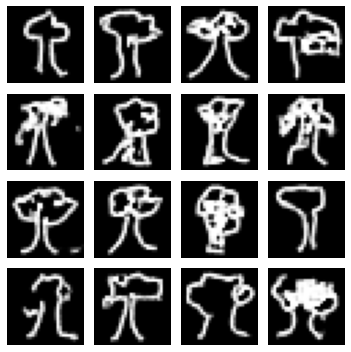

8500
Epoch #8600
8599: [D loss: 0.538338, acc: 0.746479]  [A loss: 2.114639, acc: 0.105631]


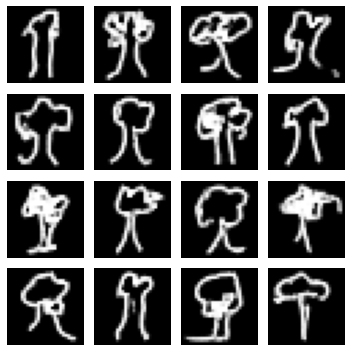

8600
Epoch #8700
8699: [D loss: 0.538533, acc: 0.746327]  [A loss: 2.111298, acc: 0.105719]


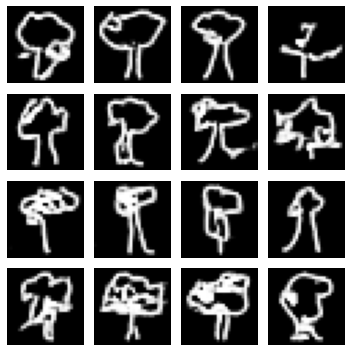

8700
Epoch #8800
8799: [D loss: 0.538780, acc: 0.746191]  [A loss: 2.108319, acc: 0.105790]


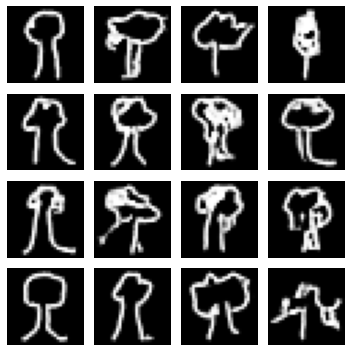

8800
Epoch #8900
8899: [D loss: 0.538904, acc: 0.746117]  [A loss: 2.106283, acc: 0.105812]


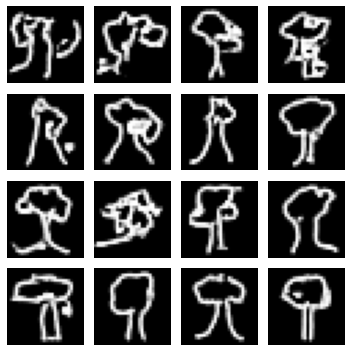

8900
Epoch #9000
8999: [D loss: 0.539191, acc: 0.745939]  [A loss: 2.102960, acc: 0.105947]


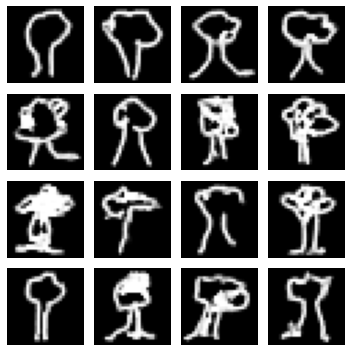

9000
Epoch #9100
9099: [D loss: 0.539341, acc: 0.745823]  [A loss: 2.099088, acc: 0.106029]


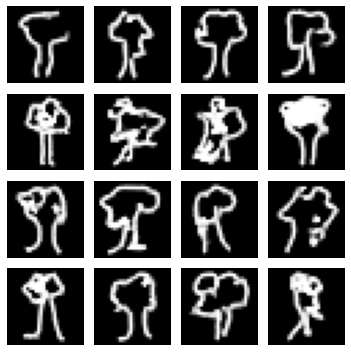

9100
Epoch #9200
9199: [D loss: 0.539373, acc: 0.745774]  [A loss: 2.097293, acc: 0.106074]


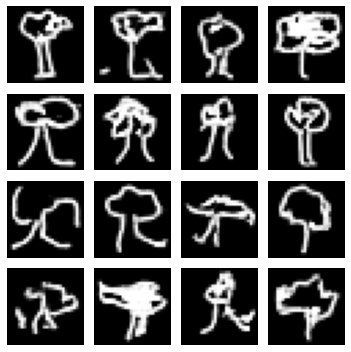

9200
Epoch #9300
9299: [D loss: 0.539613, acc: 0.745645]  [A loss: 2.095248, acc: 0.106186]


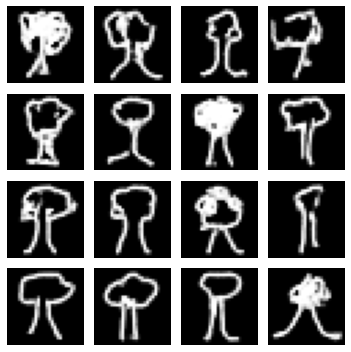

9300
Epoch #9400
9399: [D loss: 0.539827, acc: 0.745505]  [A loss: 2.091745, acc: 0.106243]


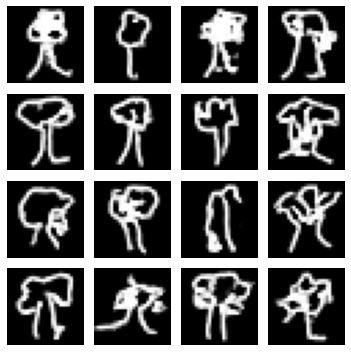

9400
Epoch #9500
9499: [D loss: 0.540132, acc: 0.745282]  [A loss: 2.086918, acc: 0.106406]


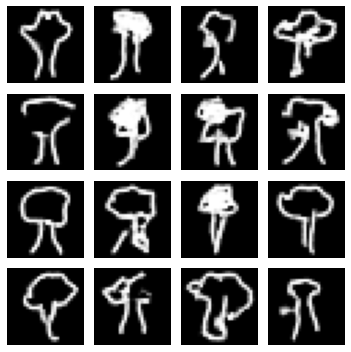

9500
Epoch #9600
9599: [D loss: 0.540412, acc: 0.745095]  [A loss: 2.083254, acc: 0.106495]


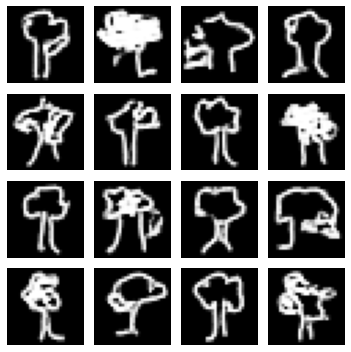

9600
Epoch #9700
9699: [D loss: 0.540557, acc: 0.744988]  [A loss: 2.079947, acc: 0.106499]


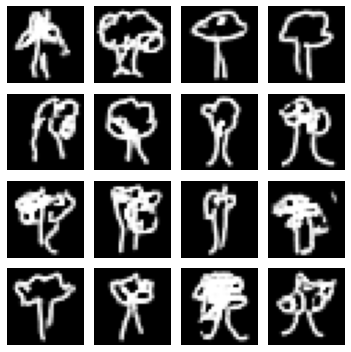

9700
Epoch #9800
9799: [D loss: 0.540848, acc: 0.744839]  [A loss: 2.076452, acc: 0.106525]


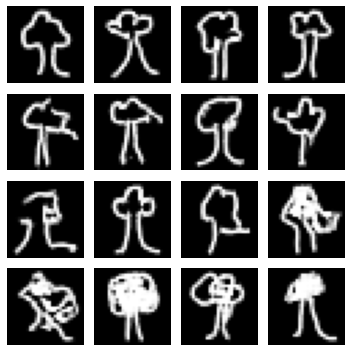

9800
Epoch #9900
9899: [D loss: 0.541127, acc: 0.744708]  [A loss: 2.073640, acc: 0.106632]


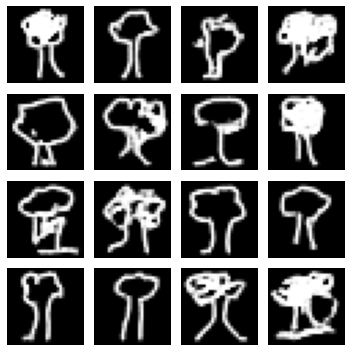

9900
Epoch #10000
9999: [D loss: 0.541342, acc: 0.744565]  [A loss: 2.070992, acc: 0.106672]


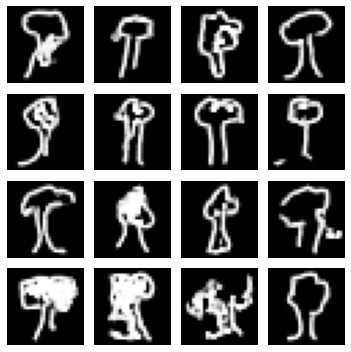

In [19]:
a_metrics_complete, d_metrics_complete = train(epochs=10000)